Pipeline Draft

There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

For the base submission we will try to classify the first and second types and leave hard labels to the full sub,ission

Overview of summary:
1) Exploratory Data Analysis - Elle/Wei
<br>
2) Image Processing and Extraction - Elle/Sai
<br>
3) Weather Prediction Attempts- Wei
<br>
3) Land Type Prediction Attempts Nick/Sai
<br>
4) Try CNNs (this is for stage 2)

5) Build a clean pipe-line per June's comment - Nick
Take the time in the beginning to make it easy to swap in and out models. This can be done a few ways. Either with helper functions inside a main notebook, or by breaking the project up into stages of pre-processing, ship the pre-processed data to each of the models, then the models ship back the predictions to a final step. But have a think through in the beginning how to set this up so that folks can simultaneously work on different models at the same time.

<br>



In [5]:
##Create Libraries
### Required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
import seaborn as sns
import cv2
# from osgeo import gdal
from skimage import io
from spectral import get_rgb
from spectral import ndvi
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier



In [11]:
##set path
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'
print(test_path1)
df = pd.read_csv('train_labels.csv')

test_jpg/


EDA
1) Things to do show variety of images (Done - Elle)
<br>
2) Show the size of the seth
<br>
2) Show volume of labels (Done - Elle) in a graph form
<br>
3) Show Correlation between Labels (Wei)
<br>
4) Create Secondary sets of labels with only easy labels, and only weather labels - Elle Done
<br>

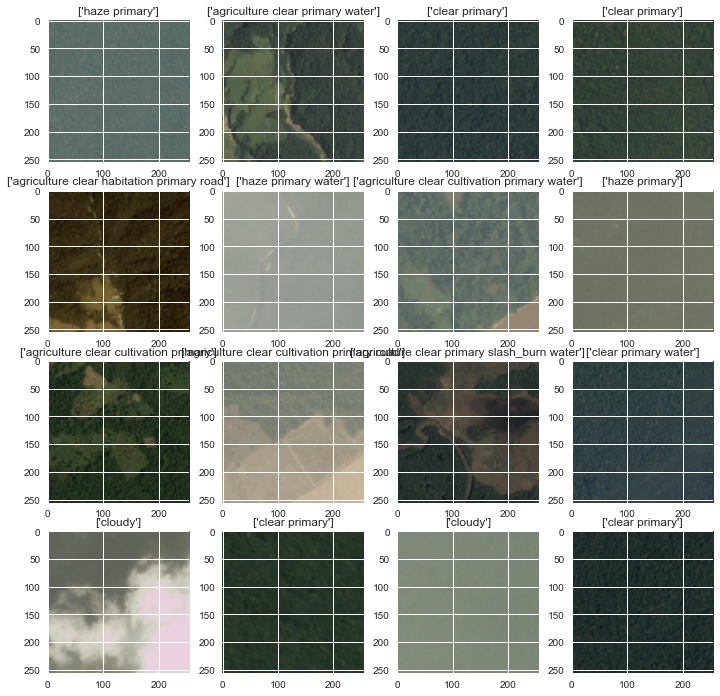

In [14]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(train_path1+'train_'+str(i)+'.jpg'))
    plt.title(str(df[df.image_name == 'train_'+str(i)].tags.values))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365 

There is 17 unique labels including {'blow_down', 'partly_cloudy', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming', 'road', 'cultivation', 'cloudy', 'haze', 'primary', 'water', 'clear', 'habitation', 'agriculture', 'bare_ground'} 



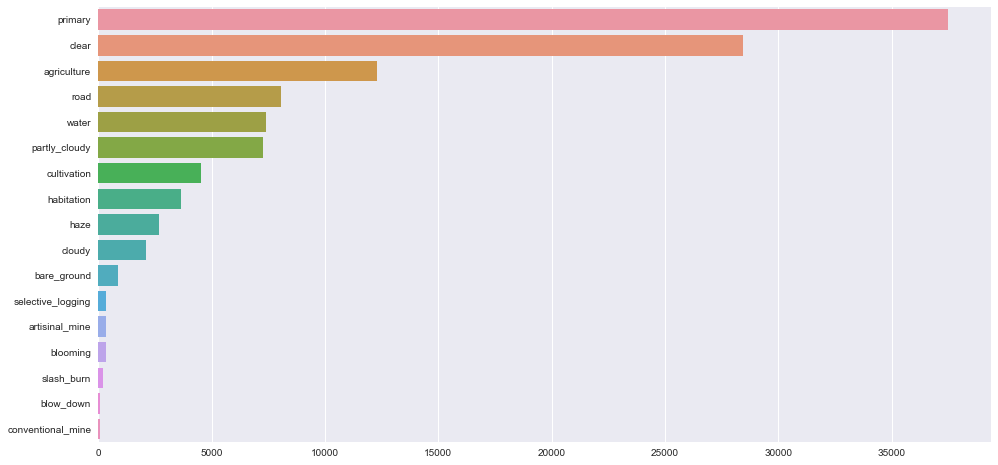

In [16]:
## View prominent tags and investigate correlations


df = pd.read_csv('train_labels.csv')

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {} \n'.format(1.0*len(all_tags)/df.shape[0]))

labels_set = set(all_tags)
print("There is {} unique labels including {} \n".format(len(labels_set), labels_set))

labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [25]:
##Simplify Problems
##Separate weather tags
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)


df_tags = df['weather'].tolist()
##Separate weather tags
test_labels=np.array(df_tags[15000:20000])
train_labels=np.array(df_tags[:15000])

def remove_tag(hard):
    hard_tags=['blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    easier_tags=hard.split()
    for i in hard_tags:
        try:
            easier_tags.remove(i)
        except:
            pass
    easier_tags=' '.join(easier_tags)
    return easier_tags
df['simpler_tags'] = df.tags.map(remove_tag)

test_labels=np.array(df_tags[15000:20000])
train_labels=np.array(df_tags[:15000])

Image Processing for weather prediction:
1) Work out how to reduce image sizes - everybody ()
<br>
2) Move, Shape, Blend, Rotate
<br>
3) Try Statistical Extraction 
Maybe this is a good approach to extract stats - we can add our road information into it:
https://www.kaggle.com/the1owl/fractals-of-nature-blend-0-90050
<br>
<br>
<br>
4) Try Feature Extraction :
<br>
Roads/ Houses via Canny edging - Sai
Water and Vegetation - Elle
Cloud - Elle
Haze removal - Elle


In [ ]:
##Model Prediction - run variety of models to identify weather, using model extraction - run a bunch of models here. 
##Work out how better to separate partly cloudy - perhaps a count for cloudy pixels

weather_jpgs=np.zeros((20000,7500))
def read_image(image_str):
    jpg_img = io.imread(train_path1+image_str)
    norm_img=jpg_img/255
    norm_img=transform.resize(norm_img, (50,50,3))
    return norm_img.flatten()
for i in range(20000):
    weather_jpgs[i,:]=read_image("train_"+str(i)+".jpg")
train_data=weather_jpgs[:15000,]
test_data=weather_jpgs[15000:20000,]


def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

#print eveyrhting
print("dev data sets")
for i in [5,10,20,50,100]:
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))

3) Try these models (this needs to be on the processed numbers) - Sai/Nick
OneVsRestClassifier
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Multi%20label%20text%20classification.ipynb

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Binary Relevance Chain 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression

Classifier CHains 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Adapted Algorithms
Multi-label nearest Neigbors
Decisions Trees
Random Forests
Neural Nets



Image Processing - how do we make the images smaller, easier size agnostic

Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up